# Autoencoder for Noise Reduction

The idea of encoding is to reduce the dimensions of input data so that the information is compressed.  The idea of decoding is to restore the original information from the compressed data.  

The autoencoder learns to encode and decode automatically (hence, the name).  As such, it is data specific and will not work on completely unseen data structure.  For example, an autoencoder trained on numbers does not work on alphabets.  Another limitation is that the compression is lossy.  It does not perfectly restore the original information.  It is, however, quite useful for noise reduction which we will see later in this notebook.

The code in this notebook is based on **Building Autoencoders in Keras by Francois Chollet** [[1]](#ref1) and **Autoencoder Examples by Udacity** [[2]](#ref2).

## MNIST

MNIST is a well known database of handwritten digits [[3]](#ref3).

In [1]:
import numpy as np
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


The below will download MNIST dataset (if not already).  We ignore the labels.

In [2]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()

The images in MNIST all have the same shape.  It has no color information.

In [3]:
X_train[0].shape

(28, 28)

Let's examine sample images.  We use 'gray' color map since it has no color information.

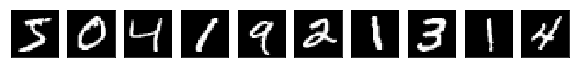

In [4]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Simple Autoencoder

To introduce the idea of autoencoders, we start with a simple implementation based on a fully connected layers.  One hidden layer handles the encoding, and the output layer handles the decoding.

Each of the input images is flatten to an array of 784 ($=28 \times 28$) data points.  This is then compressed into 32 data points by the fully connected layer.

In [5]:
inputs  = Input(shape=(784,))              # 28*28 flatten
enc_fc  = Dense( 32, activation='relu')    # compress using 32 neurons
encoded = enc_fc(inputs)

Then, we decode the encoded data to the original 784 data points.  The sigmoid will return values between 0 and 1.

In [6]:
dec_fc  = Dense(784, activation='sigmoid') # decompress to 784 pixels
decoded = dec_fc(encoded) 

This whole processing becomes the trainable autoencoder model.  It is compressing and decompressing.  So, what's the point?  We talk about that later on.

In [7]:
# build the model to train
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Let's preprocess the MNIST image data so that image data are normalized between 0 and 1.

In [8]:
def preprocess(x):
    x = x.astype('float32') / 255.
    return x.reshape(-1, np.prod(x.shape[1:])) # flatten

X_train = preprocess(X_train)
X_test  = preprocess(X_test)

# also create a validation set for training
X_train, X_valid = train_test_split(X_train, test_size=500)

Now, we train the autoencoder which compress the input image and then restore to the original size.  As such, our training data and label data are both the same image data.

In [9]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_valid, X_valid))

Train on 59500 samples, validate on 500 samples
Epoch 1/50
59500/59500 [==============================] - 1s - loss: 0.2255 - val_loss: 0.1586
Epoch 2/50
59500/59500 [==============================] - 1s - loss: 0.1415 - val_loss: 0.1277
Epoch 3/50
59500/59500 [==============================] - 1s - loss: 0.1190 - val_loss: 0.1122
Epoch 4/50
59500/59500 [==============================] - 0s - loss: 0.1072 - val_loss: 0.1037
Epoch 5/50
59500/59500 [==============================] - 0s - loss: 0.1007 - val_loss: 0.0993
Epoch 6/50
59500/59500 [==============================] - 0s - loss: 0.0974 - val_loss: 0.0972
Epoch 7/50
59500/59500 [==============================] - 0s - loss: 0.0957 - val_loss: 0.0959
Epoch 8/50
59500/59500 [==============================] - 0s - loss: 0.0949 - val_loss: 0.0953
Epoch 9/50
59500/59500 [==============================] - 0s - loss: 0.0944 - val_loss: 0.0949
Epoch 10/50
59500/59500 [==============================] - 0s - loss: 0.0941 - val_loss: 0.0946
E

Once the autoencoder is trained, we can use the encoding part to encode MNIST digit images.  By training an autoencoder, we are really training both the encoder and the decoder at the same time which is why the above training is done.

In [10]:
encoder = Model(inputs, encoded)

Now, we can compress MNIST images.

In [11]:
X_test_encoded = encoder.predict(X_test)

We can confirm the 784 pixels are now compressed into 32 data points.

In [12]:
X_test_encoded[0].shape

(32,)

Let's also build the decoder so that we can decode the encoded information into the original image size.  For the decoder, the input shape takes 32 data points as that is the size of encoded data.

In [13]:
decoder_inputs = Input(shape=(32,))
decoder = Model(decoder_inputs, dec_fc(decoder_inputs))

Let's decompress the compressed MNIST images.

In [14]:
X_test_decoded = decoder.predict(X_test_encoded)

The first row is the original image and the second row is the restored image.

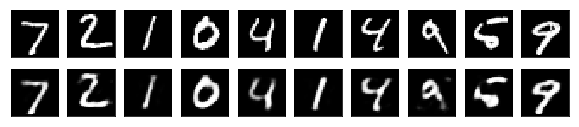

In [15]:
def show_images(before_images, after_images):
    plt.figure(figsize=(10, 2))
    for i in range(10):
        # before
        plt.subplot(2, 10, i+1)
        plt.imshow(before_images[i].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        # after
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(after_images[i].reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
show_images(X_test, X_test_decoded)

As can be seen, the decoded images do not completely restore the original image.

## Convolutional Autoencoder

We could add more layers to make the network deeper to improve the performance.  But since we are working on images, we could make use of convolutional neural network to improve the quality of compression and decompression.

In [16]:
def make_convolutional_autoencoder():
    # encoding
    inputs = Input(shape=(28, 28, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling2D(padding='same')(x)    
    
    # decoding
    x = Conv2D( 8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling2D()(x)
    x = Conv2D( 8, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    x = Conv2D(16, 3, activation='relu')(x) # <= padding='valid'!
    x = UpSampling2D()(x)
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)    
    
    # autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

Let's make a convolutional autoencoder and examine the layers.

In [17]:
autoencoder = make_convolutional_autoencoder()

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

The `UpSampling2D` will repeats the rows and columns twice.  Effectively reversing the effect of the `MaxPooling2D`.

If you look closely, the `UpSampling2D` is doubling the height and width: (4,4) => (8,8) => (16,16).  But the `conv2d_13 (Conv2D)` uses the `padding='valid'` which is the default and reduces the height and width = (14,14) so that we can up sample again to (28,28).  This is a minor details but important in practice.

Let's reshape the image data to the format the convolutional autoencoder expects for training.

In [18]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_valid = X_valid.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_valid, X_valid))

Train on 59500 samples, validate on 500 samples
Epoch 1/50
59500/59500 [==============================] - 3s - loss: 0.2166 - val_loss: 0.1483
Epoch 2/50
59500/59500 [==============================] - 2s - loss: 0.1375 - val_loss: 0.1307
Epoch 3/50
59500/59500 [==============================] - 2s - loss: 0.1261 - val_loss: 0.1227
Epoch 4/50
59500/59500 [==============================] - 2s - loss: 0.1198 - val_loss: 0.1176
Epoch 5/50
59500/59500 [==============================] - 2s - loss: 0.1157 - val_loss: 0.1140
Epoch 6/50
59500/59500 [==============================] - 2s - loss: 0.1126 - val_loss: 0.1116
Epoch 7/50
59500/59500 [==============================] - 2s - loss: 0.1105 - val_loss: 0.1103
Epoch 8/50
59500/59500 [==============================] - 2s - loss: 0.1088 - val_loss: 0.1083
Epoch 9/50
59500/59500 [==============================] - 2s - loss: 0.1075 - val_loss: 0.1074
Epoch 10/50
59500/59500 [==============================] - 3s - loss: 0.1064 - val_loss: 0.1064
E

We just want to see the quality of compression/decompression.  So, let's just feed forward test images to see how the restored digits look like.

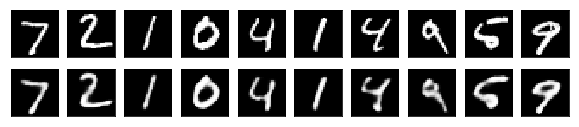

In [19]:
X_test_decoded = autoencoder.predict(X_test)

show_images(X_test, X_test_decoded)

Although not perfect, the restored digits look better than the ones restored by the simple autoencoder.

## Noise Reduction by Autoencoder

Let's try noise reduction effect using the convolutional autoencoder.  We add random noises to the MINST image data and use them as input for training.  

In [20]:
def add_noise(x, noise_factor=0.2):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
    
X_train_noisy = add_noise(X_train)
X_valid_noisy = add_noise(X_valid)
X_test_noisy  = add_noise(X_test)

We train a new autoencoder with the noisy data as input and the original data as expected output.

In [21]:
autoencoder = make_convolutional_autoencoder()
autoencoder.fit(X_train_noisy, X_train, epochs=50, batch_size=128, validation_data=(X_valid_noisy, X_valid))

Train on 59500 samples, validate on 500 samples
Epoch 1/50
59500/59500 [==============================] - 4s - loss: 0.2438 - val_loss: 0.1688
Epoch 2/50
59500/59500 [==============================] - 3s - loss: 0.1528 - val_loss: 0.1458
Epoch 3/50
59500/59500 [==============================] - 3s - loss: 0.1394 - val_loss: 0.1373
Epoch 4/50
59500/59500 [==============================] - 3s - loss: 0.1334 - val_loss: 0.1336
Epoch 5/50
59500/59500 [==============================] - 3s - loss: 0.1285 - val_loss: 0.1273
Epoch 6/50
59500/59500 [==============================] - 3s - loss: 0.1242 - val_loss: 0.1232
Epoch 7/50
59500/59500 [==============================] - 3s - loss: 0.1207 - val_loss: 0.1200
Epoch 8/50
59500/59500 [==============================] - 3s - loss: 0.1180 - val_loss: 0.1182
Epoch 9/50
59500/59500 [==============================] - 3s - loss: 0.1159 - val_loss: 0.1157
Epoch 10/50
59500/59500 [==============================] - 3s - loss: 0.1143 - val_loss: 0.1145
E

We pass the noisy images to the autoencoder to see the restored images.

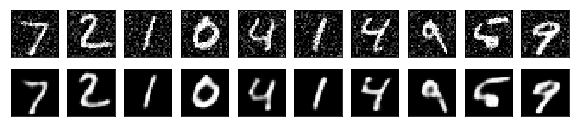

In [22]:
X_test_decoded = autoencoder.predict(X_test_noisy)

show_images(X_test_noisy, X_test_decoded)

Not bad, right?

## References

<a id="ref1"></a>
### [1] Building Autoencoders in Keras
 
Francois Chollet
  
https://blog.keras.io/building-autoencoders-in-keras.html
 
<a id="ref2"></a> 
### [2] Autoencoder Example in Tensorflow
 
Udacity
 
https://github.com/udacity/deep-learning/tree/master/autoencoder
 
<a id="ref3"></a>
### [3] MNIST dataset
 
Yann LeCun
 
http://yann.lecun.com/exdb/mnist/